### Goals of this notebook:
#### Mostly used to build things that will find their way into .py files. 
1. Build object detection dataset and dataloader.
    - Visualize a labeled example
    - Print metrics for bounding-box labeled images.
2. Copy relevant numpy data into a new train and val split directories
    - Get path from the .csv
    - Copy bounding box labels over in a pytorch-friendly manner
3. Load PyTorch image detection model
    - Train on a smaller version of the dataset
    - Experiment with 2 different architectures in torchvision.detection
4. Train PyTorch model, get classification metrics
    - May not be very good, that's alright

In [36]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import pickle as pkl
import glob

from tqdm.notebook import tqdm
sys.path.append("../")
import constants

### Goal 1a: Build object detection dataset and dataloader.

In [37]:
df = pd.read_csv("../dataset/BBox_List_2017.csv")
print("Num examples:", len(df))
df.head()

Num examples: 984


,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


In [38]:
print(f"Disease counts:\n{df['Finding Label'].value_counts()}")
print()
df["area"] = np.array(df["w"]) * np.array(df["h]"])
print(df.groupby("Finding Label").area.median())

Disease counts:
Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Pneumothorax     98
Mass             85
Nodule           79
Name: Finding Label, dtype: int64

Finding Label
Atelectasis      19665.951110
Cardiomegaly    179210.477073
Effusion         58400.408177
Infiltrate       59376.155391
Mass             15467.143269
Nodule            4800.065718
Pneumonia        59967.266224
Pneumothorax     37548.167696
Name: area, dtype: float64


In [86]:
def display_bbox_image(idx):
    path = df.iloc[idx]["Image Index"].split(".")[0] + ".npy"
    x, y, w, h = df.iloc[idx, 2:6]
    
    np_dir = "../dataset/numpy_classification_data/"
    for d in ["train/", "test/", "val/"]:
        try:
            img = np.load(np_dir + d + path)
        except FileNotFoundError:
            pass
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    print(img.shape)
    rect=mpatches.Rectangle((x, y),h,w, 
                            fill = False,
                            color = "red",
                            linewidth = 4,
                            linestyle="-.")
    plt.gca().add_patch(rect)
    plt.show()
    

(1024, 1024)


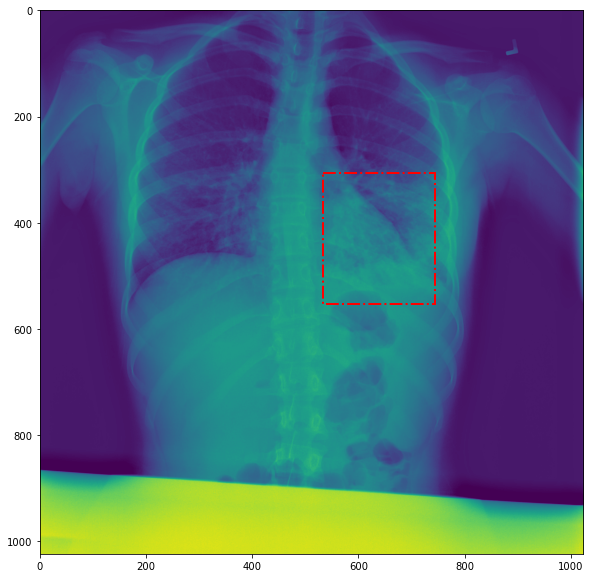

In [90]:
display_bbox_image(800)

### Goal 2: Copy relevant images into new dataset.

In [41]:
bbox_path = "../dataset/numpy_bbox_data/"

def copy_relevant_data(df, idx, split="train"):
    
    # copy over image data
    path = df.iloc[idx]["Image Index"].split(".")[0] + ".npy"
    np_dir = "../dataset/numpy_classification_data/"
    
    for d in ["train/", "test/", "val/"]:
        try:
            img = np.load(np_dir + d + path)
        except FileNotFoundError:
            pass
    
    np.save(bbox_path + split + "/" + path, img)
    
    
    # create and copy over bounding box and label data
    # matching format here: 
    # https://pytorch.org/vision/main/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html
    x, y, w, h = df.iloc[idx, 2:6]
    label = df.iloc[idx]["Finding Label"]
    label_idx = np.array([constants.LABELS_TO_IDXS[label]])
    
    x1 = x 
    x2 = x + w
    
    y1 = y 
    y2 = y + h
    
    corners = np.array([x1, y1, x2, y2])
    corners = np.expand_dims(corners, 0)
    
    d = {}
    d['boxes'] = torch.from_numpy(corners).float()
    d['labels'] = torch.from_numpy(label_idx).long()
    
    pkl.dump(d, open(bbox_path + split + "_labels" + "/" + path.split(".")[0] + ".pkl", "wb"))
    
    
    

In [42]:
df

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8,area
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN,6871.772479
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN,58150.021258
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN,33652.858374
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN,7801.344441
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN,15673.289285
...,...,...,...,...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889,NaN,NaN,NaN,198898.038202
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556,NaN,NaN,NaN,6596.967032
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556,NaN,NaN,NaN,25679.755694
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778,NaN,NaN,NaN,25327.641284


In [43]:
sample = df.sample(frac=.85, random_state=1)
sample_imgs = sample["Image Index"].tolist()

train_df = df[df["Image Index"].isin(sample_imgs)].copy()
val_df = df[~df["Image Index"].isin(sample_imgs)].copy()

train_df["split"] = "train"
val_df["split"] = "val"

print(train_df["Finding Label"].value_counts(normalize=True))
print(val_df["Finding Label"].value_counts(normalize=True))

final_df = pd.concat([train_df, val_df], axis=0)

Atelectasis     0.181609
Effusion        0.162069
Cardiomegaly    0.142529
Infiltrate      0.126437
Pneumonia       0.124138
Pneumothorax    0.093103
Mass            0.087356
Nodule          0.082759
Name: Finding Label, dtype: float64
Atelectasis     0.192982
Cardiomegaly    0.192982
Pneumothorax    0.149123
Infiltrate      0.114035
Pneumonia       0.105263
Effusion        0.105263
Mass            0.078947
Nodule          0.061404
Name: Finding Label, dtype: float64


In [44]:
dataset_splits = final_df["split"].tolist()
for idx, split in tqdm(zip(range(len(final_df)), dataset_splits)):
    copy_relevant_data(final_df, idx, split)

0it [00:00, ?it/s]

### Goal 1b: Build a Dataloader

In [91]:
# Hey sam, you made a mistake, should not use these pre-process transforms if you can help it, want to maintain full size of the image. May need to rescale some things. 
def get_preprocess_transforms():
    """
    Returns a torchvision.transforms composition to apply.
    Note that mean/std were computed via the script within utils.py
    """

    preprocess_transforms = T.Compose([
        # T.Resize(224),
        T.Normalize(
            mean=[129.1120817169278],
            std=[64.12445895568287]
        )
    ])
    
    return preprocess_transforms

class CXR_Detection_Dataset(Dataset):
    """
    Multi-label classification task for chest x-ray dataset.
    """
    def __init__(self, mode='train'):
        self.transform = get_preprocess_transforms()
        if mode == 'train':
            self.data_path = constants.DETECTION_TRAIN_DIR
            self.label_path = constants.DETECTION_TRAIN_LABELS_DIR
        elif mode == 'val':
            self.data_path = constants.DETECTION_VAL_DIR
            self.label_path = constants.DETECTION_VAL_LABELS_DIR
        else:
            print(f'Error: mode should be one of [train, val, test] but got {mode} instead.')

        # --- Construct mapping from indices to examples ---
        self.data_filenames = sorted(list(glob.glob(os.path.join("../", self.data_path, '*'))))
        self.label_filenames = sorted(list(glob.glob(os.path.join("../", self.label_path, '*'))))
        
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def __getitem__(self, idx):
        
        # --- Load the numpy array and convert into a torch tensor ---
        x = torch.from_numpy(np.load(self.data_filenames[idx])).float().unsqueeze(0)
        # --- Some of the tensors have channels for some reason... ---
        if len(x.shape) == 4:
            x = x[:, :, :, 0]
        x = self.transform(x)
        with open(self.label_filenames[idx], "rb") as f: 
            y = pkl.load(f)

        return x, y

    def __len__(self):
        return len(self.data_filenames)

In [133]:
def evaluate(model, data_loader):
    
    with torch.no_grad():
        val_losses = []

        for images, dicts in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{"boxes" : box.to(device), "labels" : label.to(device).long()} for box, label in zip(dicts["boxes"], dicts["labels"])]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            val_losses.append(losses.item())

        print("Val loss:", np.mean(val_losses))

def train_one_epoch(model, optimizer, train_loader, device, epoch, val_loader, lr_scheduler):
    model.train()
    print(f"Epoch [{epoch}]")
    epoch_loss = []
    for idx, (images, dicts) in enumerate(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{"boxes" : box.to(device), "labels" : label.to(device).long()} for box, label in zip(dicts["boxes"], dicts["labels"])]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # losses += torch.abs(torch.Tensor([len(]))
        # try to force the model to predict a single bounding box
        
        epoch_loss.append(losses.item())
        
        
        # if idx % print_every == 0:
        #     print(losses.item())
        #     print(loss_dict)
        #     print()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    lr_scheduler.step(np.mean(epoch_loss))
    
    print(f"Train loss: {np.mean(epoch_loss)}")
    evaluate(model, val_loader)
    

In [ ]:
# alright let's try to train it:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = num_classes=max(constants.LABELS_TO_IDXS.values()) + 1
train_dset = CXR_Detection_Dataset()
val_dset = CXR_Detection_Dataset(mode="val")

train_loader = torch.utils.data.DataLoader(
        train_dset, batch_size=16, shuffle=True, num_workers=4)

val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=16, shuffle=False, num_workers=4)

model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=False, num_classes=num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, cooldown=3, verbose=True, threshold=.01)
num_epochs = 100

for epoch in tqdm(range(num_epochs)):
    # train one epoch
    train_one_epoch(model, optimizer, train_loader, device, epoch, val_loader, lr_scheduler)
    # evaluate on val dataset

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [0]
Train loss: 0.5437371000355365
Val loss: 0.268614811822772
Epoch [1]
Train loss: 0.28499943017959595
Val loss: 0.2585267908871174
Epoch [2]
Train loss: 0.2893277660888784
Val loss: 0.22293994668871164
Epoch [3]
Train loss: 0.27389631318111046
Val loss: 0.26897295750677586
Epoch [4]
Train loss: 0.26572756498467687
Val loss: 0.27501361444592476
Epoch [5]
Train loss: 0.2725243144759945
Val loss: 0.2211479526013136
Epoch [6]
Train loss: 0.2555098863793354
Val loss: 0.2568856906145811
Epoch [7]
Train loss: 0.27059631896953956
Val loss: 0.31021375209093094
Epoch [8]
Train loss: 0.27151889719215094
Val loss: 0.21081130299717188
Epoch [9]
Train loss: 0.25175804688650016
Val loss: 0.35091338865458965
Epoch [10]
Train loss: 0.24166158345692298
Val loss: 0.2767832800745964
Epoch [11]


Model drew 0 bounding boxes.
tensor([11], device='cuda:0')
703.7156 616.9979 922.1689 866.17126
Model drew 1 bounding boxes.
tensor([0], device='cuda:0')
268.41684 208.26187 362.91733 445.55573
Model drew 0 bounding boxes.
tensor([5], device='cuda:0')
588.3937 275.23386 798.61163 554.8021
Model drew 0 bounding boxes.
tensor([0], device='cuda:0')
412.8508 468.1143 961.1513 969.8201
Model drew 4 bounding boxes.
tensor([8], device='cuda:0')
237.54395 120.04449 460.22168 389.02582
Model drew 1 bounding boxes.
tensor([7], device='cuda:0')
268.86566 578.28845 438.8244 672.1699
Model drew 1 bounding boxes.
tensor([11], device='cuda:0')
659.29144 425.55725 791.8516 639.29
Model drew 0 bounding boxes.
tensor([11], device='cuda:0')
310.99258 242.72592 532.0466 603.564
Model drew 0 bounding boxes.
tensor([0], device='cuda:0')
368.42328 332.66455 848.45715 706.5058
Model drew 1 bounding boxes.
tensor([0], device='cuda:0')
621.253 508.36127 890.3223 685.2881
Model drew 0 bounding boxes.
tensor([6],

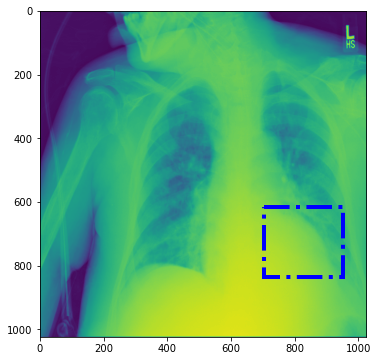

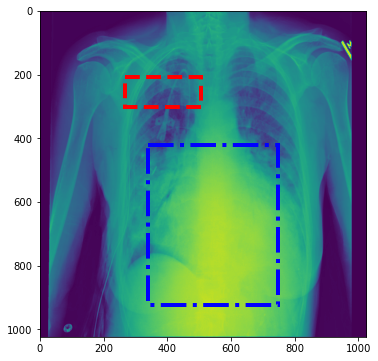

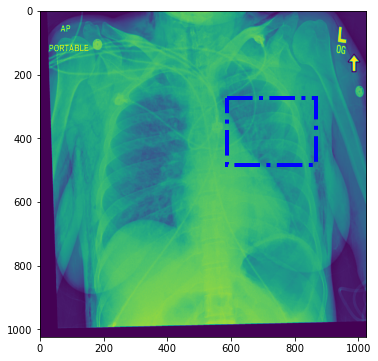

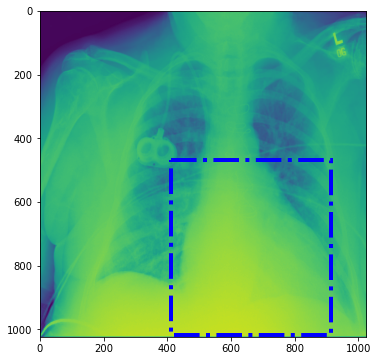

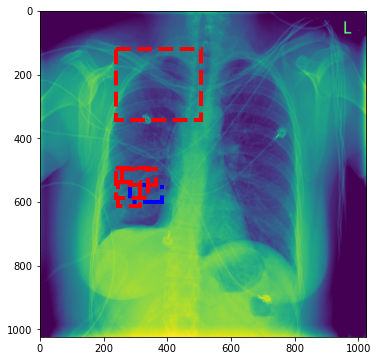

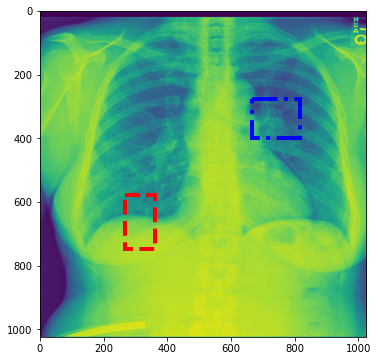

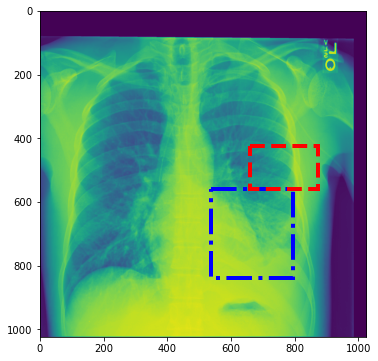

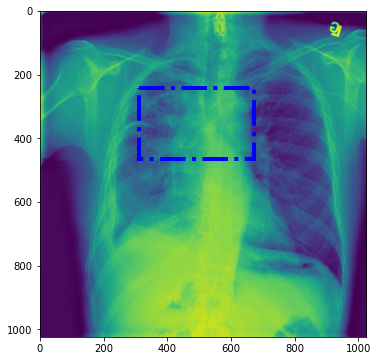

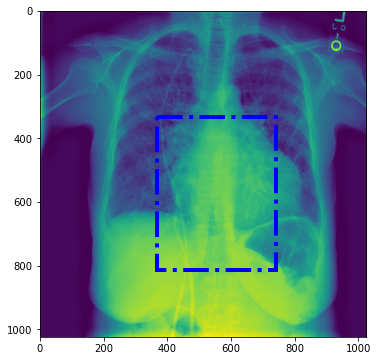

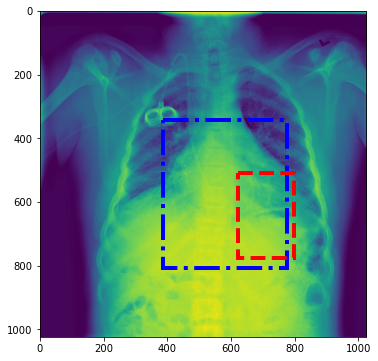

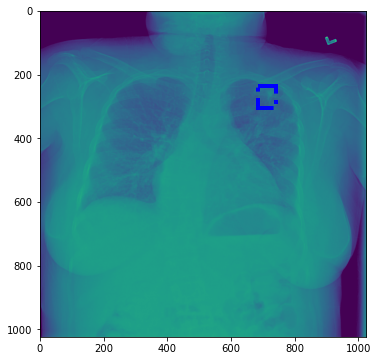

In [135]:
# let's look at the outputs! 
val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=1, shuffle=False, num_workers=4)
model.eval()
count = 0
with torch.no_grad():
    for images, dicts in val_loader:
        images = list(image.to(device) for image in images)
        targets = [{"boxes" : box.to(device), "labels" : label.to(device).long()} for box, label in zip(dicts["boxes"], dicts["labels"])]

        predictions = model(images)
        print(f"Model drew {len(predictions[0]['boxes'])} bounding boxes.")

        img = np.moveaxis(images[0].cpu().numpy(), 0, -1)
        plt.figure(figsize=(6,6))
        plt.imshow(img)

        # show actual prediction
        d = targets[0]
        x1, y1, x2, y2 = d['boxes'].cpu().numpy()[0]

        rect=mpatches.Rectangle((x1, y1),y2-y1,x2-x1, 
                                fill = False,
                                color = "blue",
                                linewidth = 4,
                                linestyle="-.")


        plt.gca().add_patch(rect)

        print(d['labels'])

        pred = predictions[0]
        for coords in pred['boxes']:
            x1, y1, x2, y2 = coords.cpu().numpy()
            rect=mpatches.Rectangle((x1, y1),y2-y1,x2-x1, 
                                fill = False,
                                color = "red",
                                linewidth = 4,
                                linestyle="--")


            plt.gca().add_patch(rect)


        print(x1, y1, x2, y2)
        count += 1

        if count > 10:
            break